## **Introduction to Image Processing**

## Interpolation and Blending

 Importing necessary libraries/modules and functions

In [1]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned OFF


### ** Resizing an image size using different interpolation functions**

**1. ** Resize the lena or vibot image using nearest, bilinear and bicubic function.

You can define your function which accept the model and resize size from the user or just run a script.

In [2]:
#function for resizing the input image
#only makes sense if the image is being enlarged
def scale_by_interpolation(in_image, scale, technique):
   
    #compute the size of the output image
    m, n = in_image.shape
    
    max_row_index_scaled = scale*(m-1)
    max_col_index_scaled = scale*(m-1)
    
    m_scaled = max_row_index_scaled + 1
    n_scaled = max_col_index_scaled + 1
    
    scaled_image = np.ones([m_scaled, n_scaled])
    
    #use inverse mapping to find nearest neighbour in original image
    if (technique == 1):
        for row in range(0, m_scaled):
            for col in range(0, n_scaled):
                inverse_mapped_row = int(np.round(row/(scale * 1.0)))
                inverse_mapped_col = int(np.round(col/(scale * 1.0)))

                scaled_image[row][col] = in_image[inverse_mapped_row][inverse_mapped_col]
    
    #use inverse mapping to find the 4x4 neighbourhood in original image
    #for bilinear interpolation
    if (technique == 2):
        for row in range(0, m_scaled):
            for col in range(0, n_scaled):
                inverse_mapped_row = row/(scale*1.0)
                inverse_mapped_col = col/(scale*1.0)
                
                floor_row = int(np.floor(inverse_mapped_row))
                ceil_row = int(np.ceil(inverse_mapped_row))
                
                floor_col = int(np.floor(inverse_mapped_col))
                ceil_col = int(np.ceil(inverse_mapped_col))
                
                a = inverse_mapped_col - floor_col
                b = inverse_mapped_row - floor_row
                
                scaled_image[row][col] = ( (1-a) * (1-b) * in_image[floor_row][floor_col] + 
                                            a*(1-b)*in_image[floor_row][ceil_col]+
                                            b*(1-a)*in_image[ceil_row][floor_col]+
                                            a*b*in_image[ceil_row][ceil_col] )  
    
    #for bicubic interpolation, I used function available in scipy, too much time to compute and
    #type 16 coefficients, plus scipy code is faster by atleast an order of magnitude!
    if (technique == 3):
        scaled_image = misc.imresize(in_image, [m_scaled, n_scaled] , interp='bicubic', mode=None)
        
    
    return(scaled_image)

In [3]:
lena = io.imread('images/lena-grey.bmp')
vibot = color.rgb2grey(io.imread('images/vibot-color.jpg'))

scaled_lena_nn = scale_by_interpolation(lena, 2, 1)
scaled_lena_bilinear = scale_by_interpolation(lena, 2, 2)
scaled_lena_bicubic = scale_by_interpolation(lena, 2, 3)



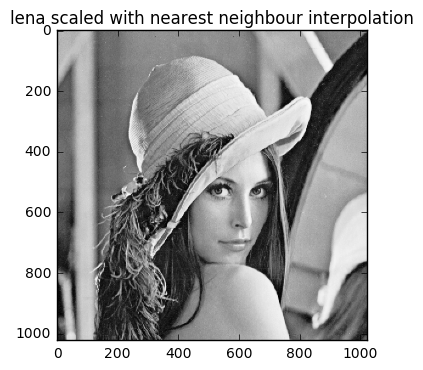

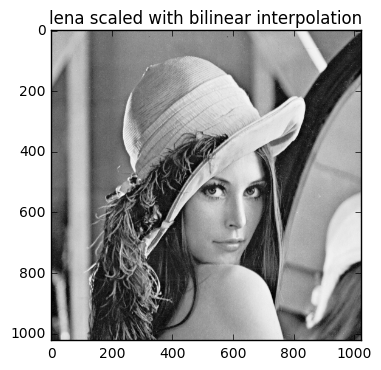

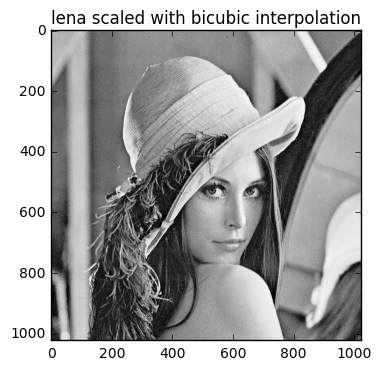

In [4]:
plt.figure()
plt.imshow(scaled_lena_nn, cmap = 'Greys_r')
plt.title('lena scaled with nearest neighbour interpolation')

plt.figure()
plt.imshow(scaled_lena_bilinear, cmap = 'Greys_r')
plt.title('lena scaled with bilinear interpolation')

plt.figure()
plt.imshow(scaled_lena_bicubic, cmap = 'Greys_r')
plt.title('lena scaled with bicubic interpolation')

import scipy.misc
scipy.misc.imsave('images/lena_bilinear_scaled2.jpg', scaled_lena_bilinear)
scipy.misc.imsave('images/lena_bicubic_scaled2.jpg', scaled_lena_bicubic)
scipy.misc.imsave('images/lena_nn_scaled2.jpg', scaled_lena_nn)

**2. ** Similar to the function of `my_blending.m` that you saw before define your function of blending.

Blend the lena image and vibot image using simple, alpha and pyramid method.   

Pyramid blending method: 
1. Create a mask the same size as your input images 
2. Create Laplacian pyramid of the input images 
    2.1. Create Gaussian pyramids of the input images
    2.2. Create Laplacian pyramids using the Gaussian pyramids
3. Create Gaussian pyramid for the region mask
4. Blend the two laplacian pyramids using the pyramid of the mask as weigh 
    $$ BL = L_1 * (GM) + L_2 *(1 - GM)$$
5. Colapse the pyramid to get the final image 
    $$rescale(rescale(rescale(BL_3)+BL_2)+BL_1)+BL_0$$

Note : For pyramid blending approach, you can use:
    * transform.rescale for upscaling your images
    * transform.pyramid_gaussian for building your pyramids
    * The output of transform.pyramid_gaussian is a type generator and you need to convert it to a list :
    
        b = [a for a in Gaussian_pyramid]


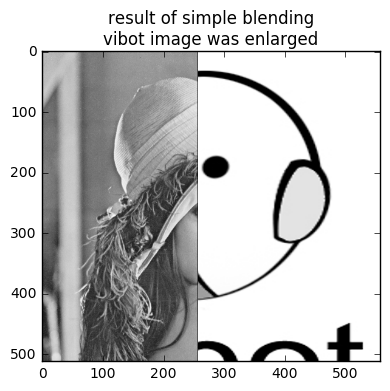

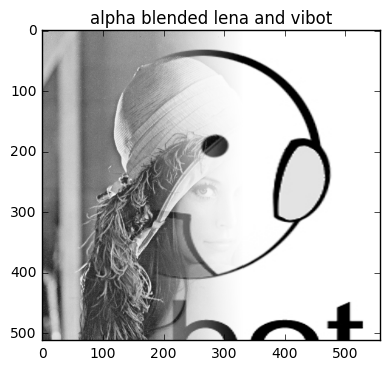

In [5]:
#lena.shape = 512x 512
#vibot.shape = 301 x 222
#Let's enlarge vibot and then crop it so that it has the same number of rows
#as lena image
vibotBig = scale_by_interpolation(vibot, 2, 3)
vibotBig = vibotBig[0:512]

mlena, nlena = lena.shape
mvibot, nvibot = vibotBig.shape

#simple blending
lenaHalf = lena[:, 0:nlena/2]
vibotHalf = vibotBig[:,nvibot/2:nvibot]

mBlImage = mlena
nBlImage = nlena/2 + nvibot/2 +2

#perform simple blending and display results
blImage = np.zeros([mBlImage, nBlImage])
blImage[:,0:nlena/2] = lenaHalf
blImage[:,nlena/2 + 1:nBlImage] = vibotHalf

plt.figure()
plt.imshow(blImage, cmap = 'Greys_r')
plt.title('result of simple blending\nvibot image was enlarged')

#perform alpha blending and display results
w = 150;
lenaBlend = lena[:,nlena/2 - w/2:nlena/2+w/2]
vibotBlend = vibotBig[:,nvibot/2 - w/2 : nvibot/2 + w/2]
blImage_alpha = blImage

for x in range(0, w):
    alpha_lena = -1.0/w*x + 1
    alpha_vibot = 1 - alpha_lena
    
    blImage_alpha[:,nlena/2 - w/2 + x] = alpha_lena*lenaBlend[:,x] + alpha_vibot * vibotBlend[:,x]

plt.figure()
plt.imshow(blImage_alpha, cmap = 'Greys_r')
plt.title('alpha blended lena and vibot')

Use the `orange.jpeg` and `apple.jpeg` imgages and blend them using simple, alpha and pyramid approach.

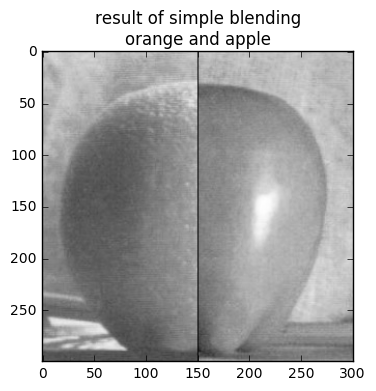

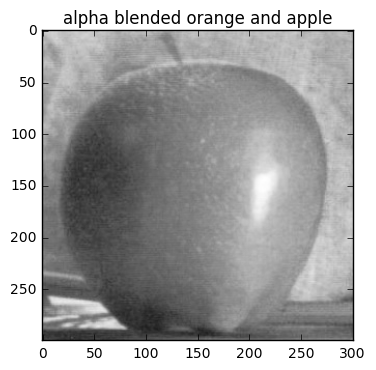

In [6]:
orange = color.rgb2gray(io.imread('images/orange.jpeg'))
apple = color.rgb2gray(io.imread('images/apple.jpeg'))

#orange.shape = 300 x 300
#apple.shape = 300 x 300

#get shapes
morange, norange = orange.shape
mapple, napple = apple.shape

#simple blending
orangeHalf = orange[:, 0:norange/2]
appleHalf = apple[:,napple/2:napple]

mBlImage2 = morange
nBlImage2 = norange/2 + napple/2 +1

#perform simple blending and display results
blImage2 = np.zeros([mBlImage2, nBlImage2])
blImage2[:,0:norange/2] = orangeHalf
blImage2[:,norange/2 + 1:nBlImage2] = appleHalf

plt.figure()
plt.imshow(blImage2, cmap = 'Greys_r')
plt.title('result of simple blending\norange and apple')

#perform alpha blending and display results
w = 200;
orangeBlend = orange[:,norange/2 - w/2:norange/2+w/2]
appleBlend = apple[:,napple/2 - w/2 : napple/2 + w/2]
blImage_alpha2 = blImage2

for x in range(0, w):
    alpha_orange = -1.0/w*x + 1
    alpha_apple = 1 - alpha_orange
    
    blImage_alpha2[:,norange/2 - w/2 + x] = alpha_orange*orangeBlend[:,x] + alpha_apple * appleBlend[:,x]

plt.figure()
plt.imshow(blImage_alpha2, cmap = 'Greys_r')
plt.title('alpha blended orange and apple')

**2. ** Similar to the function of `my_blending.m` that you saw before define your function of blending.

Blend the lena image and vibot image using simple, alpha and pyramid method.   

Pyramid blending method: 
1. Create a mask the same size as your input images 
2. Create Laplacian pyramid of the input images 
    2.1. Create Gaussian pyramids of the input images
    2.2. Create Laplacian pyramids using the Gaussian pyramids
3. Create Gaussian pyramid for the region mask
4. Blend the two laplacian pyramids using the pyramid of the mask as weigh 
    $$ BL = L_1 * (GM) + L_2 *(1 - GM)$$
5. Colapse the pyramid to get the final image 
    $$rescale(rescale(rescale(BL_3)+BL_2)+BL_1)+BL_0$$

Note : For pyramid blending approach, you can use:
    * transform.rescale for upscaling your images
    * transform.pyramid_gaussian for building your pyramids
    * The output of transform.pyramid_gaussian is a type generator and you need to convert it to a list :
    
        b = [a for a in Gaussian_pyramid]


In [7]:
#function for computing a MATLAB style Gaussian kernel

import numpy as np

def gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

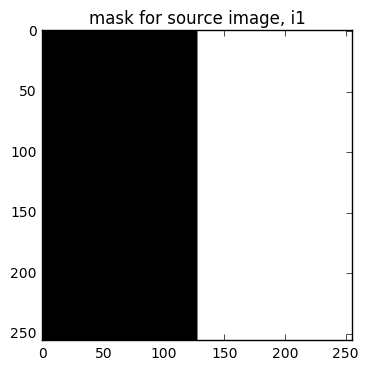

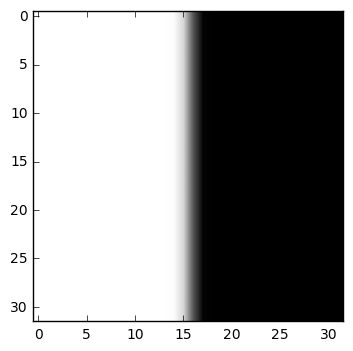

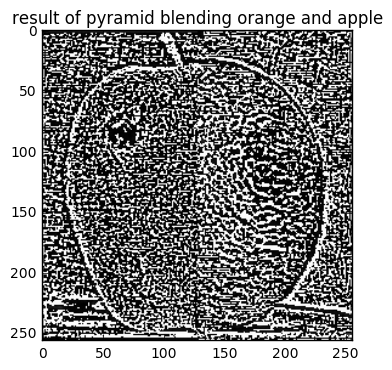

In [10]:
#pyramid blending not performed for lena and vibot since they are of different sizes
#cropping and/or changing aspect ratio is necessary for making them the same size
from scipy.ndimage import gaussian_filter
from scipy.misc import imresize
from skimage.transform import rescale
from scipy.ndimage import convolve

gaussian_kernel = gauss2D((5,5), 1.5)


#resize orange and apple so that their dimensions are powers of 2
orange = color.rgb2gray(io.imread('images/orange.jpeg'))
apple = color.rgb2gray(io.imread('images/apple.jpeg'))
orange = imresize(orange, (256, 256), interp='bicubic', mode=None)
apple = imresize(apple, (256, 256), interp='bicubic', mode=None)

#create and display the mask
mask = np.zeros(orange.shape)
mmask, nmask = mask.shape
for x in range(nmask/2, nmask):
    mask[:,x] = 1
plt.figure()
plt.imshow(mask, cmap = 'Greys_r')
plt.title ('mask for source image, i1')

i1 = orange
i2 = apple


#construct gaussian and laplacian pyramids
#gaussians and laplacians for i1
g0_i1 = i1
smooth_g0_i1 = convolve (g0_i1, gaussian_kernel)

g1_i1 = rescale(smooth_g0_i1, 0.5, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
smooth_g1_i1 = convolve (g1_i1, gaussian_kernel)

g2_i1 = rescale(smooth_g1_i1, 0.5, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
smooth_g2_i1 = convolve (g2_i1, gaussian_kernel)

g3_i1 = rescale(smooth_g2_i1, 1.0/2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)

l0_i1 = g0_i1 - smooth_g0_i1
l1_i1 = g1_i1 - smooth_g1_i1
l2_i1 = g2_i1 - smooth_g2_i1
l3_i1 = g3_i1

#gaussians and laplacians for i2
g0_i2 = i2
smooth_g0_i2 = convolve (g0_i2, gaussian_kernel)

g1_i2 = rescale(smooth_g0_i2, 1.0/2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
smooth_g1_i2 = convolve (g1_i2, gaussian_kernel)

g2_i2 = rescale(smooth_g1_i2, 1.0/2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
smooth_g2_i2 = convolve (g2_i2, gaussian_kernel)

g3_i2 = rescale(smooth_g2_i2, 1.0/2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)

l0_i2 = g0_i2 - smooth_g0_i2
l1_i2 = g1_i2 - smooth_g1_i2
l2_i2 = g2_i2 - smooth_g2_i2
l3_i2 = g3_i2

#gaussian pyramid for mask
g0_m = mask
smooth_g0_m = convolve (g0_m, gaussian_kernel)

g1_m = rescale(smooth_g0_m, 1.0/2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
smooth_g1_m = convolve (g1_m, gaussian_kernel)

g2_m = rescale(smooth_g1_m, 1.0/2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
smooth_g2_m = convolve (g2_m, gaussian_kernel)

g3_m = rescale(smooth_g2_m, 1.0/2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)

#calculate laplacians using gaussian pyramid of mask
l3_combined = g3_m * l3_i1 + (1 - g3_m) * l3_i2
l2_combined = g2_m * l2_i1 + (1 - g2_m) * l2_i2
l1_combined = g1_m * l1_i1 + (1 - g1_m) * l1_i2
l0_combined = g0_m * l0_i1 + (1 - g0_m) * l0_i2
# l3_combined = l3_i2 
# l2_combined = l2_i2 
# l1_combined = l1_i2 
# l0_combined = l0_i2 

#collapse the combined laplacians for reconstruction of blended image using mask m
collapse0 = l2_combined + rescale(l3_combined, 2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
collapse1 = l1_combined + rescale(collapse0, 2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
collapse2 = l0_combined + rescale(collapse1, 2, order=1, mode='constant', cval=0, clip=True, preserve_range=False)

blended_image = np.floor(collapse2)
plt.figure()
plt.imshow(blended_image, cmap = 'Greys_r')
plt.title('result of pyramid blending orange and apple')